Model comparison for 9 different kernel combination. Each inputs have the same kernel combinations. The kernel combinations all have length=3.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior
from gpytorch.constraints import constraints

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood

Load data

In [2]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set6 = [
    "viper_launched",
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "cobra_launched",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set7 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set8 = [
    "norm_viper_briefed_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_briefed_launch_range",
    "norm_cobra_briefed_evasion_range",
]

viper_portion_cols = [
    'viper_p_NEUTRAL', 
    'viper_p_DEFENSIVE',
    'viper_p_HEADON', 
    'viper_p_OFFENSIVE'
]

cobra_portion_cols = [
    'cobra_p_NEUTRAL', 
    'cobra_p_DEFENSIVE',
    'cobra_p_HEADON', 
    'cobra_p_OFFENSIVE'
]

response1 = ["outcome"]
response2 = ["outcome"] + viper_portion_cols
response3 = ["outcome"] + viper_portion_cols + cobra_portion_cols
response4 = ["outcome"] + viper_portion_cols + cobra_portion_cols + ["viper_launched"] + ["cobra_launched"]

In [3]:

path = "../../ace0/msl_evasion-005/msl_evasion-case-5_edited.csv"
df = pd.read_csv(path, index_col=0)
# if subset_data:
#     df = df.groupby('outcome').sample(frac=.3, random_state=2172)
#     df.reset_index(drop=True, inplace=True)

# X = torch.tensor(df_copy[input_set5].values, dtype=torch.float)
X = torch.tensor(df[input_set8].values, dtype=torch.float)
# Need to torch.float for y, since we have categorical and proportions
y = torch.tensor(df[response4].values, dtype=torch.float)

In [4]:


# if not subset_data:
#     train_idx, test_idx = torch.utils.data.random_split(X, [.6, .4], \
#         generator=torch.Generator().manual_seed(80))
#     train_idx, test_idx = train_idx.indices, test_idx.indices

#     train_x = X[train_idx,:]
#     test_x = X[test_idx,:]
#     train_y = y[train_idx,:]
#     test_y = y[test_idx,:]
# else:   
#     train_idx = df.groupby('outcome').sample(frac=subset_data, random_state=308).index
#     test_idx = np.array(list(set(df.index) - set(train_idx)))
#     train_x = X[train_idx,:]
#     test_x = X[test_idx,:]
#     train_y = y[train_idx,:]
#     test_y = y[test_idx,:]

In [5]:
def get_kernel(ks, batch_shape, independent_outputs, additive, lengthscale_prior, active_dims=None):
    
    global input_dims
    
    if independent_outputs:
        assert active_dims is not None, "insert active_dims"
    
    # to compare additive and non-additive model
    if additive:
        ard_num_dims = None
    else:
        ard_num_dims = input_dims     

    args = {
            "lengthscale_prior":lengthscale_prior,
            "batch_shape":batch_shape,
            "ard_num_dims":ard_num_dims,
            "active_dims": active_dims
        }
    
    # ks: kernel_string
    if ks == "SE":
        return RBFKernel(**args)
    elif ks == "M32":
        args.update({"nu": 3/2})
        return MaternKernel(**args)
    elif ks == "M52": 
        args.update({"nu": 5/2})
        return MaternKernel(**args)
    elif ks == "Lin":
        args.pop("lengthscale_prior")
        return LinearKernel(**args)
    elif ks == "PPoly0":
        args.update({"q":0})
        return PiecewisePolynomialKernel(**args)
    elif ks == "PPoly1":
        args.update({"q":1})
        return PiecewisePolynomialKernel(**args)
    elif ks == "PPoly2":
        args.update({"q":2})
        return PiecewisePolynomialKernel(**args)
    elif ks == "PPoly3":
        args.update({"q":3})
        return PiecewisePolynomialKernel(**args)
    else:
        raise ValueError(f"Kernel string {ks} is not a valid kernel.")
    
def get_kernel_combination(kc, independent_outputs, additive, lengthscale_prior, batch_shape=None, dim=None, scale_kernel=False, outputscale_prior=None):
    # kc: kernel combination
    
    if not independent_outputs:
        batch_shape=torch.Size([1])
    else:
        assert batch_shape is not None, "insert batch"
        if not isinstance(batch_shape,torch.Size):
            batch_shape = torch.Size([batch_shape])
        batch_shape=batch_shape
        
    if additive:
        assert dim is not None, "insert dim"
        dim = [dim]
    else:
        dim = list(range(input_dims))
        
    def get_k_add(kernel, batch_shape, independent_outputs, additive, active_dims=None, scale_kernel=False, outputscale_prior=None):

        if isinstance(kernel, tuple):
            kernel1, kernel2 = kernel
            k_add = ProductKernel(get_kernel(kernel1, batch_shape, independent_outputs, additive, lengthscale_prior, active_dims), get_kernel(kernel2, batch_shape, independent_outputs, additive, lengthscale_prior, active_dims))
        elif isinstance(kernel, str):
            k_add = get_kernel(kernel, batch_shape, independent_outputs, additive, lengthscale_prior, active_dims)
        else:
            raise ValueError("kernel elements must be either string or tuple.")
        
        if scale_kernel:
            outputscale_constraint = constraints.Interval(0,1)
            k_add = ScaleKernel(k_add, outputscale_prior=outputscale_prior, outputscale_constraint=outputscale_constraint)
        
        return k_add
        
    combin = []
    active_dims = []
    k_add = []
    for kernel in kc:
        if not independent_outputs:
            k_add = get_k_add(kernel, batch_shape, independent_outputs, additive, scale_kernel=scale_kernel, outputscale_prior=outputscale_prior)
            combin.append(k_add)
        else:
            for i in range(input_dims):
                k_tmp = get_k_add(kernel, batch_shape, independent_outputs, additive, active_dims=i, scale_kernel=scale_kernel, outputscale_prior=outputscale_prior)
                k_add.append(k_tmp)
    if independent_outputs:
        k_add = AdditiveKernel(*k_add)
        combin.append(k_add)
    active_dims.extend([dim for _ in range(len(combin))])
    # kernel_combin.append(combin)
    if not independent_outputs:
        return combin, active_dims
    else:
        return combin, None

In [6]:
# generate kernels
def generate_kernel_combinations(kernel_combination_str, lengthscale_prior_code, independent_outputs=False, additive=True, scale_kernel=False, outputscale_prior_code=None):
    
    global input_dims
    kernel_combin = []
    kernel_combin_nonadd = []
    kernel_combin_ind = collections.defaultdict(collections.defaultdict)
    likelihoods = ["Categorical", "HetDirichlet", "HetDirichlet", "Bernoulli", "Bernoulli"]
    active_dims = []
    
    if lengthscale_prior_code == 0:
            lengthscale_prior = None
    elif lengthscale_prior_code == 1:
            gamma_mean = 2.
            gamma_std = 2.
            alpha = gamma_mean**2 / np.sqrt(gamma_std)
            beta = gamma_mean / np.sqrt(gamma_std)
            lengthscale_prior = GammaPrior(alpha, beta)   

    if outputscale_prior_code == None:
        outputscale_prior = None
    elif outputscale_prior_code == 2:
        outputscale_prior = BetaPrior(.15, .15)
    
    for i, combin in enumerate(kernel_combination_str):
        if not independent_outputs:
            kc = []
            ad = []
            if additive:
                for dim in range(input_dims):
                    kc0, ad0 = get_kernel_combination(combin, independent_outputs, additive, lengthscale_prior, dim=dim, scale_kernel=scale_kernel, outputscale_prior=outputscale_prior)
                    kc.extend(kc0)
                    ad.extend(ad0)
                kernel_combin.append(kc)
                active_dims.append(ad)
            else:
                kc, ad = get_kernel_combination(combin, independent_outputs, additive, lengthscale_prior, scale_kernel=scale_kernel, outputscale_prior=outputscale_prior)
                kernel_combin_nonadd.append(kc)
                active_dims.append(ad)
        else:
            num_lpf_list = [4, 5, 5, 1, 1]
            for likelihood, num_lpf in zip(likelihoods, num_lpf_list):
                kc, ad = get_kernel_combination(combin, independent_outputs, additive, lengthscale_prior, dim=0, batch_shape=num_lpf, scale_kernel=scale_kernel, outputscale_prior=outputscale_prior)
                kernel_combin_ind[i][likelihood] = kc
        if not independent_outputs:
            active_dims.append(ad)
        else:
            active_dims = None
                
    if not independent_outputs and additive:
        return kernel_combin, active_dims
    elif independent_outputs and additive:
        return kernel_combin_ind, active_dims
    elif not independent_outputs and not additive:
        return kernel_combin_nonadd, active_dims

In [7]:
# basis_kernels = ["SE", "M32", "M52", "Lin", "PPoly2", "PPoly3"]

# allowable_addition = {
#     "SE": ["SE", "M32", "M52", "Lin", "PPoly2", "PPoly3"],
#     "M32": ["SE", "Lin", "PPoly2", "PPoly3"],
#     "M52": ["SE", "Lin", "PPoly2", "PPoly3",],
#     "Lin": ["SE", "M32", "M52", "Lin", "PPoly2", "PPoly3"],
#     "PPoly2": ["SE", "Lin"],
#     "PPoly3": ["SE", "Lin"],
# }

# allowable_products = {
#     "SE": ["M32", "M52", "Lin", "PPoly2", "PPoly3"],
#     "M32": ["SE", "Lin"],
#     "M52": ["SE", "Lin"],
#     "Lin": ["SE", "M32", "M52", "Lin", "PPoly2", "PPoly3"],
#     "PPoly2": ["SE", "Lin"],
#     "PPoly3": ["SE", "Lin"],
# }

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, neg_elbo):
        if neg_elbo < self.min_validation_loss:
            self.min_validation_loss = neg_elbo
            self.counter = 0
        elif neg_elbo > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [9]:
def get_kernel_parameters(model, independent_outputs=False, prefix=""):

    kernel_parameters = collections.defaultdict(collections.defaultdict)

    if not independent_outputs:
        kernel_modules = model.covar_module.kernel_modules
    else:
        kernel_modules = model.covar_module.sub_kernels()
    
    for i, module in enumerate(kernel_modules):
        # Should always be True since we are using ScaleKernels
        k_parent = f"{prefix}Kernel.{i}"
        if isinstance(module, ScaleKernel):
            kernel = module.base_kernel
        else:
            kernel = module
        if isinstance(kernel, (ProductKernel, AdditiveKernel)):
            # Sub kernels within ProductKernel / AdditiveKernel
            for j, ksub in enumerate(kernel.kernels):
                op_kernel_str = kernel._get_name()
                k_name = f"{op_kernel_str}.{j}.{ksub._get_name()}"
                kernel_parameters[k_parent][k_name] = collections.defaultdict(dict)
                for name, raw_value, constraint in ksub.named_parameters_and_constraints():
                    param = name.split("_")[-1]
                    value = constraint.transform(raw_value).detach().cpu().flatten().numpy()
                    value = np.round(value, 4)
                    kernel_parameters[k_parent][k_name][param] = value
                if hasattr(ksub, "nu"):
                    kernel_parameters[k_parent][k_name]["nu"] = ksub.nu
        else:
            k_name = f"{kernel._get_name()}"
            kernel_parameters[k_parent][k_name] = collections.defaultdict(collections.defaultdict)
            for name, raw_value, constraint in kernel.named_parameters_and_constraints():
                    param = name.split("_")[-1]
                    value = constraint.transform(raw_value).detach().cpu().flatten().numpy()
                    value = np.round(value, 4)                    
                    kernel_parameters[k_parent][k_name][param] = value
            if hasattr(kernel, "nu"):
                kernel_parameters[k_parent][k_name]["nu"] = kernel.nu
        for name, raw_value, constraint in module.named_parameters_and_constraints():
            if "outputscale" in name:
                param = name.split("_")[-1]
                value = constraint.transform(raw_value).detach().cpu().flatten().numpy()
                value = np.round(value, 4)                    
                kernel_parameters[k_parent][param] = value
    
    return kernel_parameters

In [10]:
def get_kernel_code(k_name):
    k_string = ""
    if "RBF" in k_name:
        k_string += "SE"
    elif "Matern" in k_name:
        k_string += "M"
    elif "Linear" in k_name:
        k_string += "Lin"
    elif "PiecewisePolynomialKernel" in k_name:
        k_string += "PPoly"
    elif "PolynomialKernel" in k_name:
        k_string += "Poly"
    elif "RQKernel" in k_name:
        k_string += "RQ"
    elif "RFFKernel" in k_name:
        k_string += "RFF"
    return k_string

def get_kernel_combination_dims(model, kcid, independent_outputs, active_dims):
    
    kernel_combination = []
    kernel_combination_full = []
    kernel_combination_dims = []
    
    nu_map = {"0.5": "12", "1.5": "32", "2.5": "52"}

    kernel_count = {
        "SE": 1,
        "M12": 1,
        "M32": 1,
        "M52": 1,
        "Lin": 1,
        "PPoly0": 1,
        "PPoly1": 1,
        "PPoly2": 1,
        "PPoly3": 1,
        "Poly": 1,
        "RQ": 1,
        "RFF": 1,
    }
    
    kernel_modules = model.covar_module.kernel_modules

    for i, module in enumerate(kernel_modules):
        k_string = ""
        if not independent_outputs:
            dim_str = str(active_dims[kcid][i][0])
        else:
            dim_str = "."
        if isinstance(module, ScaleKernel):
            kernel = module.base_kernel
        else:
            kernel = module
        if isinstance(kernel, (ProductKernel, AdditiveKernel)):
            # Sub kernels within ProductKernel / AdditiveKernel
            k_group = []
            for j, ksub in enumerate(kernel.kernels):
                k_name = str(ksub._get_name())
                if hasattr(ksub, "nu"):
                    nu = nu_map[str(ksub.nu)]
                    k_code = get_kernel_code(k_name)
                    k_code += nu
                elif hasattr(ksub, "q"):
                    q = str(ksub.q)
                    k_code = get_kernel_code(k_name)
                    k_code += q
                else:
                    k_code = get_kernel_code(k_name)
                k_name = k_code + "_" + str(kernel_count[k_code]) + f"^({dim_str})"
                k_group.append(k_name)
                kernel_count[k_code] += 1
            kernel_combination.append(tuple(k_group))
            kernel_combination_full.append(" x ".join(k_group))
        else:
            k_name = str(kernel._get_name())
            if hasattr(kernel, "nu"):
                nu = nu_map[str(kernel.nu)]
                k_code = get_kernel_code(k_name)
                k_code += nu
            elif hasattr(kernel, "q"):
                q = str(kernel.q)
                k_code = get_kernel_code(k_name)
                k_code += q
            else:
                k_code = get_kernel_code(k_name)
                k_name = k_code
            k_name = k_code + "_" + str(kernel_count[k_code]) + f"^({dim_str})"
            kernel_count[k_code] += 1
            kernel_combination.append(k_name)
            kernel_combination_full.append(k_name)

    for i,k in enumerate(iterable=kernel_combination_full):
        if i == 0:
            k_name = kernel_combination_full[0]
            dim_pre = active_dims[kcid][0][0]
        elif i < len(kernel_combination_full)-1:
            dim = active_dims[kcid][i][0]
            if dim_pre == dim:
                k_name += f" + {k}"
            else:
                kernel_combination_dims.append(k_name)
                k_name = k
                dim_pre = dim
        else:
            k_name += f" + {k}"
            kernel_combination_dims.append(k_name)
    
    return kernel_combination_dims

In [11]:
def compute_metrics(model=None, model_list=None, likelihoods=None,test_id=None, kcid=None, additive=None, independent_outputs=None, lmc_prior_code=None, lengthscale_prior_code=None, subset=None):
    # global independent_outputs
    # global test_id
    # global kcid
    # global lmc_prior_code
    # global lengthscale_prior_code
    
    global loo_df
    global loo_train_df
    global waic_df
    global waic_train_df
    global nlpd_df
    global agreement_df
    global msce_df
    
    loo_dict = collections.defaultdict(collections.defaultdict)
    loo_train_dict = collections.defaultdict(collections.defaultdict)
    nlpd_dict = collections.defaultdict(collections.defaultdict)
    agreement_dict = collections.defaultdict(collections.defaultdict)
    msce_dict = collections.defaultdict(collections.defaultdict)
    waic_dict = collections.defaultdict(collections.defaultdict)
    waic_train_dict = collections.defaultdict(collections.defaultdict)
    
    stats_dictlist = [loo_dict, loo_train_dict, waic_dict, waic_train_dict, nlpd_dict, 
                      agreement_dict, msce_dict]
    

    for stats_dict in stats_dictlist:
        stats_dict["test_id"] = test_id
        stats_dict["kcid"] = kcid
        stats_dict["lmc_prior_code"] = lmc_prior_code
        stats_dict["lengthscale_prior_code"] = lengthscale_prior_code
        stats_dict["subset"] = subset

    # pyro.set_rng_seed(88)
    # create samples
    if not independent_outputs:
        # include return_sites in Predictive for faster execution
        predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
        predictions = predictive_dist(test_x, None, n_categories=4, n_compositions=[4, 4])
        y0_pred = predictions["hmogp.y_0"].median(0)[0].squeeze(0).cpu().numpy()
        y1_pred = predictions['hmogp.y_1'].mean(0)[0].squeeze(0).cpu().numpy()
        y2_pred = predictions['hmogp.y_2'].mean(0)[0].squeeze(0).cpu().numpy()
        y3_pred = predictions['hmogp.y_3'].median(0)[0].squeeze(0).cpu().numpy()
        y4_pred = predictions['hmogp.y_4'].median(0)[0].squeeze(0).cpu().numpy()
        f_samples = predictions["hmogp.f(x)"].cpu()

        predictions_train = predictive_dist(train_x, None, n_categories=4, n_compositions=[4, 4])
        y0_pred_train = predictions_train["hmogp.y_0"].median(0)[0].squeeze(0).cpu().numpy()
        y1_pred_train = predictions_train["hmogp.y_1"].mean(0)[0].squeeze(0).cpu().numpy()
        y2_pred_train = predictions_train["hmogp.y_2"].mean(0)[0].squeeze(0).cpu().numpy()
        y3_pred_train = predictions_train["hmogp.y_3"].median(0)[0].squeeze(0).cpu().numpy()
        y4_pred_train = predictions_train["hmogp.y_4"].median(0)[0].squeeze(0).cpu().numpy()
        f_samples_train = predictions_train["hmogp.f(x)"].cpu()
    else:
        predictive_dist = []
        predictive_dist_train = []
        y_preds = []
        y_preds_train = []
        f_samples = torch.empty((300,test_x.size(0), 16))
        f_samples_train = torch.empty((300,train_x.size(0), 16))
        dims = [list(range(4)), list(range(4,9)), list(range(9,14)), [14],[15]]
        for i, model in enumerate(model_list):
            predictive_dist = Predictive(model.model, guide=model.guide, num_samples=300)
            predictions = predictive_dist(test_x, None, n_categories=4, n_compositions=[4, 4])
            predictions_train = predictive_dist(train_x, None, n_categories=4, n_compositions=[4, 4])
            # each pred is now hmogp.y_0 because d_counter will always be equal to 0
            if i in [1, 2]:
                pred = predictions[f"hmogp.y_0"].mean(0)[0].squeeze(0).cpu().numpy()
                pred_train = predictions_train[f"hmogp.y_0"].mean(0)[0].squeeze(0).cpu().numpy()
            elif i in [0, 3, 4]:
                pred = predictions[f'hmogp.y_0'].median(0)[0].squeeze(0).cpu().numpy()
                pred_train = predictions_train[f"hmogp.y_0"].mode(0)[0].squeeze(0).cpu().numpy()
            y_preds.append(pred)
            y_preds_train.append(pred_train)
            f_samples[...,dims[i]] = predictions["hmogp.f(x)"].cpu()
            f_samples_train[...,dims[i]] = predictions_train["hmogp.f(x)"].cpu()          
            # break
            
    # compute log likelihoods
    log_likelihood = compute_log_likelihood(f_samples, likelihoods, test_y, n_compositions=[4,4])
    log_likelihood_xr = xr.Dataset(
        {"log_likelihood": (("chain", "draw", "index", "response"), np.expand_dims(log_likelihood, axis=0))},
        coords={
            "chain": [0],
            "draw": np.arange(log_likelihood.shape[0]),
            "index": np.arange(log_likelihood.shape[1]),
            "response": [f"y{d}" for d in range(log_likelihood.shape[2])]
        }
    )
    posterior_xr = xr.Dataset(
        {"lpf_iq": (("chain", "draw", "index", "q"), f_samples.unsqueeze(0).numpy())},
        coords={
            "chain": [0],
            "draw": np.arange(f_samples.shape[0]),
            "index": np.arange(f_samples.shape[1]),
            "q": np.arange(f_samples.shape[-1]),
        }
    )
    az_data = az.InferenceData(log_likelihood=log_likelihood_xr,
                            posterior=posterior_xr)

    # train data
    log_likelihood_train = compute_log_likelihood(f_samples_train, likelihoods, train_y, n_compositions=[4,4])

    log_likelihood_xr_train = xr.Dataset(
        {"log_likelihood": (("chain", "draw", "index", "response"), np.expand_dims(log_likelihood_train, axis=0))},
        coords={
            "chain": [0],
            "draw": np.arange(log_likelihood_train.shape[0]),
            "index": np.arange(log_likelihood_train.shape[1]),
            "response": [f"y{d}" for d in range(log_likelihood_train.shape[2])]
        }
    )
    posterior_xr_train = xr.Dataset(
        {"lpf_iq": (("chain", "draw", "index", "q"), f_samples_train.unsqueeze(0).numpy())},
        coords={
            "chain": [0],
            "draw": np.arange(f_samples_train.shape[0]),
            "index": np.arange(f_samples_train.shape[1]),
            "q": np.arange(f_samples_train.shape[-1]),
        }
    )
    az_data_train = az.InferenceData(log_likelihood=log_likelihood_xr_train,
                            posterior=posterior_xr_train)
    
    
    # compute loo
    test_loo = az.loo(az_data)
    train_loo = az.loo(az_data_train)

    bins = np.asarray([-np.Inf, 0.5, 0.7, 1, np.Inf])
    pareto_k, _ = np.histogram(test_loo.pareto_k.values, bins=bins)
    pareto_k_train, _ = np.histogram(train_loo.pareto_k.values, bins=bins)

    test_loo = test_loo.to_dict()
    train_loo = train_loo.to_dict()
    
    # update_keys = list(set(test_loo.keys()) - {"loo_i", "pareto_k"})
    k = [f"elpd_loo_y{i}" for i in range(5)]
    loo_i = test_loo["loo_i"].values.sum(0)
    loo_i_dict = {k:round(v,5) for (k,v) in zip(k, loo_i)}
    loo_i_train = train_loo["loo_i"].values.sum(0)
    loo_i_train_dict = {k:round(v,5) for (k,v) in zip(k, loo_i_train)}
    remove_keys = ["loo_i", "pareto_k"]
    for key in remove_keys:
        test_loo.pop(key, None)
        train_loo.pop(key, None)

    pareto_k_label = ["k_count_good", "k_count_ok", "k_count_bad", "k_count_verybad"]
    for i, label in enumerate(pareto_k_label):
        test_loo[label] = pareto_k[i]
        train_loo[label] = pareto_k_train[i]

    loo_dict["test_data"] = 1
    loo_train_dict["test_data"] = 0
    loo_dict.update(test_loo)
    loo_dict.update(loo_i_dict)
    loo_train_dict.update(train_loo)
    loo_train_dict.update(loo_i_train_dict)
    
    # compute waic
    test_waic = az.waic(az_data)
    train_waic = az.waic(az_data_train)

    test_waic = test_waic.to_dict()
    train_waic = train_waic.to_dict()
    
    # update_keys = list(set(test_loo.keys()) - {"loo_i", "pareto_k"})
    k = [f"elpd_waic_y{i}" for i in range(5)]
    waic_i = test_waic["waic_i"].values.sum(0)
    waic_i_dict = {k:round(v,5) for (k,v) in zip(k, waic_i)}
    waic_i_train = train_waic["waic_i"].values.sum(0)
    waic_i_train_dict = {k:round(v,5) for (k,v) in zip(k, waic_i_train)}
    remove_keys = ["waic_i"]
    for key in remove_keys:
        test_waic.pop(key, None)
        train_waic.pop(key, None)
    
    waic_dict["test_data"] = 1
    waic_train_dict["test_data"] = 0
    waic_dict.update(test_waic)
    waic_dict.update(waic_i_dict)
    waic_train_dict.update(train_waic)
    waic_train_dict.update(waic_i_train_dict)
    
    # compute nlpd
    nlpd_scores = compute_nlpd(log_likelihood, test_y)
    for key,val in zip(["y" + str(i) for i in range(5)],nlpd_scores):
        nlpd_dict[key] = val
        
    # compute msce
    y0_test = test_y[...,0].numpy()
    y1_test = test_y[...,1:5].numpy()
    y2_test = test_y[...,5:9].numpy()
    y3_test = test_y[...,9].numpy()
    y4_test = test_y[...,10].numpy()

    if independent_outputs:
        y1_pred = y_preds[1]
        y2_pred = y_preds[2]
        
    y1_msce = mean_sum_composition_errors(y1_pred, y1_test)
    y2_msce = mean_sum_composition_errors(y2_pred, y2_test)

    msce_dict["y1"] = y1_msce
    msce_dict["y2"] = y2_msce
    
    # compute agreements
    weight_type = ["unweighted", "linear", "quadratic"]
    y_class = ["y0", "y3", "y4"]
    y_test_class = [y0_test, y3_test, y4_test]

    if independent_outputs:
        y0_pred = y_preds[0]
        y3_pred = y_preds[3]
        y4_pred = y_preds[4]
        
    y_pred_class = [y0_pred, y3_pred, y4_pred]

    for weight in weight_type:
        for y, y_test, y_pred in zip(y_class, y_test_class, y_pred_class):
            cm = confusion_matrix(y_test, y_pred)
            agreement_dict["weight"] = weight
            agreement_dict[y] = scotts_pi(cm, weight_type=weight)
        agreement_df = agreement_df.append(agreement_dict, ignore_index=True)

    loo_df = loo_df.append(loo_dict, ignore_index=True)
    loo_train_df = loo_train_df.append(loo_train_dict, ignore_index=True)
    waic_df = waic_df.append(waic_dict, ignore_index=True)
    waic_train_df = waic_train_df.append(waic_train_dict, ignore_index=True)
    nlpd_df = nlpd_df.append(nlpd_dict, ignore_index=True)
    msce_df = msce_df.append(msce_dict, ignore_index=True)

In [12]:
# WARNING! CAREFUL NOT TO RUN THIS CELL

def start(test_id, kcid, additive, independent_outputs, lmc_prior_code, lengthscale_prior_code, subset):

    global lengthscales_df
    global lmc_df
    global loo_df
    global loo_train_df
    global waic_df
    global waic_train_df
    global nlpd_df
    global agreement_df
    global msce_df
    global kernel_structure_df
    global compute_times_df
    
    global input_dims
    global active_dims
    global active_dims_ind
    global active_dims_nonadd
    global kernel_combin
    global kernel_combin_ind
    global kernel_combin_nonadd
    global n_kernels_per_input
    
    # run in each new scenario
    lengthscales_dict = collections.defaultdict(collections.defaultdict)
    lmc_dict = collections.defaultdict(collections.defaultdict)
    loo_dict = collections.defaultdict(collections.defaultdict)
    loo_train_dict = collections.defaultdict(collections.defaultdict)
    waic_dict = collections.defaultdict(collections.defaultdict)
    waic_train_dict = collections.defaultdict(collections.defaultdict)
    nlpd_dict = collections.defaultdict(collections.defaultdict)
    agreement_dict = collections.defaultdict(collections.defaultdict)
    msce_dict = collections.defaultdict(collections.defaultdict)
    kernel_structure_dict = collections.defaultdict(collections.defaultdict)
    compute_times_dict = collections.defaultdict(collections.defaultdict)

    model_stats_dictlist = [lengthscales_dict, lmc_dict, loo_dict, loo_train_dict, waic_dict, waic_train_dict, nlpd_dict, agreement_dict, msce_dict, kernel_structure_dict, compute_times_dict,]

    test_id = test_id
    kcid = kcid # kernel combination id
    subset = subset

    additive = additive
    independent_outputs = independent_outputs

    lmc_prior_code = lmc_prior_code
    lengthscale_prior_code = lengthscale_prior_code

    n_kernels_per_input = n_kernels_per_input

    for stats_dict in model_stats_dictlist:
        stats_dict["test_id"] = test_id
        stats_dict["kcid"] = kcid
        stats_dict["lmc_prior_code"] = lmc_prior_code
        stats_dict["lengthscale_prior_code"] = lengthscale_prior_code
        stats_dict["subset"] = subset
        
    kernel_structure_dict["n_kernels"] = n_kernels_per_input
    kernel_structure_dict["additive"] = additive
    kernel_structure_dict["independent_outputs"] = independent_outputs
    
    if lmc_prior_code == 0:
        low = torch.tensor(-50, dtype=torch.float, device=train_x.device)
        high = torch.tensor(50, dtype=torch.float, device=train_x.device)
        lmc_coefficients_prior = UniformPrior(low, high)
    elif lmc_prior_code == 1:
            lmc_coefficients_prior = gpytorch.priors.NormalPrior(0,3)
    elif lmc_prior_code == 2:
            lmc_coefficients_prior = HorseshoePrior(.5)
            # lmc_coefficients_prior = HorseshoePrior(torch.tensor([.5]).expand([len(active_dims[kcid]), 16]))
    if lengthscale_prior_code == 0:
            lengthscale_prior = None
    elif lengthscale_prior_code == 1:
            gamma_mean = 2.
            gamma_std = 2.
            alpha = gamma_mean**2 / np.sqrt(gamma_std)
            beta = gamma_mean / np.sqrt(gamma_std)
            lengthscale_prior = GammaPrior(alpha, beta)
    
    # training model
    likelihoods = ["Categorical", "HetDirichlet", "HetDirichlet", "Bernoulli", "Bernoulli"]
    if not independent_outputs and additive:
        model = HetMOGP(train_x, num_lpf=16, likelihoods=likelihoods, kernels=kernel_combin[kcid], active_dims=active_dims[kcid], num_inducing=100, jitter_val = 1e-3, n_compositions=[4, 4], 
                        lmc_coefficients_prior=lmc_coefficients_prior,
                        independent_outputs=independent_outputs,
                        )
        # print("Running: Proposed model.")
    elif independent_outputs and additive:
        model_list = []
        num_lpf_list = [4, 5, 5, 1, 1]
        for likelihood, num_lpf in zip(likelihoods, num_lpf_list):
            m = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], 
                        kernels=kernel_combin_ind[kcid][likelihood][0],
                            active_dims=active_dims_ind, num_inducing=100, jitter_val = 1e-3, n_compositions=4, lmc_coefficients_prior=lmc_coefficients_prior, independent_outputs=independent_outputs,
                            )
            model_list.append(m)
        # print("Running: Independent output model.")
    elif not independent_outputs and not additive:
        model = HetMOGP(train_x, num_lpf=16, likelihoods=likelihoods, kernels=kernel_combin_nonadd[kcid], active_dims=active_dims_nonadd[kcid], num_inducing=100, jitter_val = 1e-3, n_compositions=[4, 4], 
                    lmc_coefficients_prior=lmc_coefficients_prior,
                    independent_outputs=independent_outputs,
                    )
        # print("Running: Non-additive model.")
    else:
        raise ValueError("invalid scenario")
    
    pyro.set_rng_seed(88)
    pyro.clear_param_store()
    
    num_iter = 3000 
    num_particles = 10

    lrd_num_iter = 700
    initial_lr = 1e-1
    final_lr = 1e-3
    gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
    lrd = gamma ** (1 / lrd_num_iter) # learning rate decay

    optimizer = pyro.optim.ClippedAdam({
        'lr': initial_lr, 
        'lrd': lrd,
        'betas': (0.93, 0.99999), # previously (0.95, 0.999),
        # 'clip_norm': 2.5,
        'clip_norm': .001, # previously 5.0
        # 'weight_decay': .01,
        })
    
    start = datetime.now()
    # iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
    loss_array = np.zeros(num_iter)
    
    iterations_to_converge = 0
    if not independent_outputs:
        early_stopper = EarlyStopper(patience=50, min_delta=0)
        elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
        svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
        model.train()
        for i in range(num_iter):
            model.zero_grad()
            loss = svi.step(x=train_x, y=train_y)
            loss_array[i] = loss     
            # iterator.set_postfix(loss=loss)
            if early_stopper.early_stop(loss) and i >= 100:
                iterations_to_converge = i
                break
    else:
        dims = [[0], list(range(1,5)), list(range(5,9)), [9], [10]]
        loss_array = np.zeros((num_iter,5))
        for q, m in enumerate(model_list):
            pyro.clear_param_store()
            early_stopper = EarlyStopper(patience=50, min_delta=0)
            elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
            svi = pyro.infer.SVI(m.model, m.guide, optimizer, elbo)
            # print("dim =", q)
            m.train()
            # iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
            for i in range(num_iter):
                m.zero_grad()
                loss = svi.step(x=train_x, y=train_y[...,dims[q]])
                loss_array[i,q] = loss
                # iterator.set_postfix(loss=loss)
                if early_stopper.early_stop(loss) and i >= 100:
                    iterations_to_converge += i
                    break
    compute_time = (datetime.now() - start).total_seconds()
    
    if not independent_outputs:
        kernel_parameters = get_kernel_parameters(model, independent_outputs=independent_outputs)
        lmc_dict["lmc_coeff"] = model.variational_strategy.lmc_coefficients.detach().cpu().flatten().numpy()
    else:
        kernel_parameters = collections.defaultdict(collections.defaultdict)
        for i, m in enumerate(model_list):
            tmp = get_kernel_parameters(m, independent_outputs=independent_outputs, prefix=f"model_y{i}_")
            kernel_parameters.update(tmp)
            lmc_dict["lmc_coeff"] = 0

    lengthscales_list = []
    for key, val in kernel_parameters.items():
        for inner_key, inner_val in val.items():
            if isinstance(inner_val, collections.defaultdict):
                if "lengthscale" in inner_val.keys():
                    lengthscales_list.extend(inner_val["lengthscale"])

    lengthscales_dict["lengthscales"] = lengthscales_list
    
    if not independent_outputs:
        kernel_structure_dict["kernel_structure"] = get_kernel_combination_dims(model=model, kcid=kcid, independent_outputs=independent_outputs, active_dims=active_dims)
    else:
        kernel_structure_dict["kernel_structure"] = ""
        
    compute_times_dict["time_to_converge"] = compute_time
    compute_times_dict["iterations_to_converge"] = iterations_to_converge
    
    lengthscales_df = lengthscales_df.append(lengthscales_dict, ignore_index=True)
    lmc_df = lmc_df.append(lmc_dict, ignore_index=True)
    kernel_structure_df = kernel_structure_df.append(kernel_structure_dict, ignore_index=True)
    compute_times_df = compute_times_df.append(compute_times_dict, ignore_index=True)

    kwargs = {
        "likelihoods":likelihoods, 
        "test_id":test_id, 
        "kcid":kcid, 
        "additive":additive, 
        "independent_outputs":independent_outputs, 
        "lmc_prior_code":lmc_prior_code, 
        "lengthscale_prior_code":lengthscale_prior_code,
        "subset": subset
    }
    
    if not independent_outputs:
        compute_metrics(model=model, **kwargs)
    else:
        compute_metrics(model_list=model_list, **kwargs)

In [13]:
lengthscale_prior_code = 1
n_kernels_per_input = 6
outputscale_prior_code = None
scale_kernel = False

combinations_len2 = [("SE", "SE"), 
                     ("SE", "PPoly2"), 
                     ("PPoly2", "PPoly2"),
                     ("SE", "M32"),                     
                    ("M32", "M32"),   
                    ("SE", "PPoly3"),                    
                     ("PPoly3", "PPoly3"),
                     ("SE", "M52"), 
                     ("M52", "M52"),                     
                    #  ('PPoly2', "M52"), 
                     (('SE', 'PPoly2'), 'SE'),                    
                     (('SE', 'M32'), 'SE'),
                      (('SE', 'PPoly3'), 'SE'),
                     (('SE', 'M52'), 'SE'),
                     (('SE', 'PPoly2'), ('SE', 'PPoly2')),
                     (('SE', 'M32'), ('SE', 'M32')),
                     (('SE', 'PPoly3'), ('SE', 'PPoly3')),                     
                     (('SE', 'M52'), ('SE', 'M52')),
                    #  (('SE', 'PPoly2'), ('SE', 'M52')),
                     ]

combinations_len3 = [("SE", "SE", "SE",),                           # 0: kcid .01
                        ("SE", "SE", "M52"),                        # 1: kcid .02
                        ("SE", "SE", "PPoly2"),                     # 2: kcid .03
                        ('SE', 'PPoly2', "M52"),                    # 3: kcid .04
                        (('SE', 'PPoly2'), 'SE', 'SE'),             # 4: kcid .05
                        (('SE', 'M52'), 'SE', 'SE'),                # 5: kcid .06
                        (('SE', 'PPoly2'), ('SE', 'PPoly2'), 'SE'), # 6: kcid .07
                        (('SE', 'M52'), ('SE', 'M52'), 'SE'),       # 7: kcid .08
                        (('SE', 'PPoly2'), ('SE', 'M52'), 'SE'),    # 8: kcid .09
                        # (('SE', 'PPoly2'), ('SE', 'PPoly1'), 'SE'), # 9: kcid .1 # added recently
                        ]

# if n_kernels_per_input == 2:
#     combinations = combinations_len2
# elif n_kernels_per_input == 4:
#     combinations_len4 = [combin * 2 for combin in combinations_len2]
#     combinations = combinations_len4
# elif n_kernels_per_input == 6:
#     combinations_len8 = [combin * 3 for combin in combinations_len2]
#     combinations = combinations_len8
# elif n_kernels_per_input == 8:
#     combinations_len8 = [combin * 4 for combin in combinations_len2]
#     combinations = combinations_len8
if n_kernels_per_input % 3 == 0:
    multiplier = n_kernels_per_input // 3
    combinations = [combin * multiplier for combin in combinations_len3]
else:
    raise ValueError("Kernel numbers not valid")

input_dims = X.size(-1)

kernel_combin, active_dims = generate_kernel_combinations(combinations, lengthscale_prior_code=lengthscale_prior_code, independent_outputs=False, additive=True, outputscale_prior_code=outputscale_prior_code, scale_kernel=scale_kernel)
kernel_combin_ind, active_dims_ind = generate_kernel_combinations(combinations, lengthscale_prior_code=lengthscale_prior_code, independent_outputs=True, additive=True, outputscale_prior_code=None, scale_kernel=scale_kernel)
kernel_combin_nonadd, active_dims_nonadd = generate_kernel_combinations(combinations, lengthscale_prior_code=lengthscale_prior_code, independent_outputs=False, additive=False, outputscale_prior_code=None, scale_kernel=scale_kernel)

In [14]:
# save_csv_path = f"./model_comparisons_v1/kernels_len_{n_kernels_per_input}"
# save_csv_path = f"./model_comparisons_v2/kernels_len_{n_kernels_per_input}"
save_csv_path = f"./model_comparisons_v4/kernels_len_{n_kernels_per_input}"
# save_csv_path = f"./model_comparisons_v5/kernels_len_{n_kernels_per_input}"
assert os.path.exists(save_csv_path)

def save_csv(df, path):
    if not os.path.isfile(path):
        df.to_csv(path)
    else:
        df.to_csv(path, mode="a", header=False)

test_grid = {
    0: {"additive": True, "independent_outputs": False, "lmc_prior_code": 2, "scale_kernel": False, "outputscale_prior_code": None}, # Proposed model
    1: {"additive": True, "independent_outputs": False, "lmc_prior_code": 0, "scale_kernel": False, "outputscale_prior_code": None}, # Proposed model without horseshoe
    2: {"additive": True, "independent_outputs": True, "lmc_prior_code": 0, "scale_kernel": False, "outputscale_prior_code": None}, # Independent outputs model
    3: {"additive": False, "independent_outputs": False, "lmc_prior_code": 0, "scale_kernel": False, "outputscale_prior_code": None}, # Non-additive model
    # 4: {"additive": True, "independent_outputs": False, "lmc_prior_code": 1}, # Proposed model without 
    # 4: {"additive": True, "independent_outputs": False, "lmc_prior_code": 2, "scale_kernel": True, "outputscale_prior_code": 2}, # Proposed model with sparse local lmc prior
    # 5: {"additive": False, "independent_outputs": False, "lmc_prior_code": 0, "scale_kernel": False, "outputscale_prior_code": None}, # Non-additive model without sparse prior
}

n_training = 10 
kcid_max = len(kernel_combin)
subset_data = [.1,.3]

for k in range(kcid_max):
    kcid = k 
    if k > 0:
        continue
    for n in range(n_training): 
        for key, val in test_grid.items():
            test_id = key
            additive = val["additive"]
            independent_outputs = val["independent_outputs"]
            lmc_prior_code = val["lmc_prior_code"]
            scale_kernel = val["scale_kernel"]
            outputscale_prior = val["outputscale_prior_code"]
            attempts = 0
            # if test_id in [0,3]:
            #     continue
            
            for subset in subset_data:
            
                train_idx = df.groupby('outcome').sample(frac=subset, random_state=308).index
                test_idx = np.array(list(set(df.index) - set(train_idx)))
                train_x = X[train_idx,:]
                test_x = X[test_idx,:]
                train_y = y[train_idx,:]
                test_y = y[test_idx,:]

                while attempts < 10:

                    identifier_list = ["test_id", "kcid", "lmc_prior_code", "lengthscale_prior_code", "subset"]
                    pareto_k_label = ["k_count_good", "k_count_ok", "k_count_bad", "k_count_verybad"]

                    lengthscales_df = pd.DataFrame(columns= identifier_list + ["lengthscales"])
                    lmc_df = pd.DataFrame(columns= identifier_list + ["lmc_coeff"])
                    loo_df = pd.DataFrame(columns= identifier_list + ["test_data", "elpd_loo", "p_loo", "se", "warning", "n_data_points", "n_samples", "scale"] + pareto_k_label + [f"elpd_loo_y{i}" for i in range(5)])
                    loo_train_df = loo_df.copy()
                    waic_df = pd.DataFrame(columns= identifier_list + ["test_data", "elpd_waic", "p_waic", "se", "warning", "n_data_points", "n_samples", "scale"] + [f"elpd_waic_y{i}" for i in range(5)])
                    waic_train_df = waic_df.copy()
                    nlpd_df = pd.DataFrame(columns= identifier_list + ["y0", "y1", "y2", "y3", "y4"])
                    agreement_df = pd.DataFrame(columns= identifier_list + ["weight", "y0", "y3", "y4"])
                    msce_df = pd.DataFrame(columns= identifier_list + ["y1", "y2"])
                    kernel_structure_df = pd.DataFrame(columns= identifier_list + ["kernel_structure", "n_kernels", "active_dims", "additive", "independent_outputs"])
                    compute_times_df = pd.DataFrame(columns= identifier_list + ["time_to_converge", "iterations_to_converge"])
                    
                    try:
                        start(test_id, kcid, additive, independent_outputs, lmc_prior_code, lengthscale_prior_code, subset)
                        nlpd_df["total_nlpd"] = nlpd_df[[f"y{i}" for i in range(5)]].sum(1)
                        
                        save_csv(lengthscales_df, os.path.join(save_csv_path, "lengthscales_df.csv"))
                        save_csv(lmc_df, os.path.join(save_csv_path, "lmc_df.csv"))
                        save_csv(loo_df, os.path.join(save_csv_path, "loo_df.csv"))
                        save_csv(loo_train_df, os.path.join(save_csv_path, "loo_train_df.csv"))
                        save_csv(waic_df, os.path.join(save_csv_path, "waic_df.csv"))
                        save_csv(waic_train_df, os.path.join(save_csv_path, "waic_train_df.csv"))
                        save_csv(nlpd_df, os.path.join(save_csv_path, "nlpd_df.csv"))
                        save_csv(agreement_df, os.path.join(save_csv_path, "agreement_df.csv"))
                        save_csv(msce_df, os.path.join(save_csv_path, "msce_df.csv"))
                        save_csv(kernel_structure_df, os.path.join(save_csv_path, "kernel_structure_df.csv"))
                        save_csv(compute_times_df, os.path.join(save_csv_path, "compute_times_df.csv"))
                        
                        print(f"Completed {n+1}x training on test_id: {test_id}, kcid: {kcid}")
                        break
                    except Exception:
                        print(traceback.format_exc())
                        attempts += 1
                        print(f"Failed attempts: {attempts}")
            print(f"Completed subset: {subset}")
    print(f"Completed kernel combination on kcid: {kcid}")

Completed 1x training on test_id: 0, kcid: 0
Completed 1x training on test_id: 0, kcid: 0
Completed subset: 0.3
Completed 1x training on test_id: 1, kcid: 0
Completed 1x training on test_id: 1, kcid: 0
Completed subset: 0.3
Completed 1x training on test_id: 2, kcid: 0
Completed 1x training on test_id: 2, kcid: 0
Completed subset: 0.3
Completed 1x training on test_id: 3, kcid: 0
Completed 1x training on test_id: 3, kcid: 0
Completed subset: 0.3
Traceback (most recent call last):
  File "/home/cao/miniconda3/envs/pytorch2/lib/python3.10/site-packages/pyro/poutine/trace_messenger.py", line 174, in __call__
    ret = self.fn(*args, **kwargs)
  File "/home/cao/miniconda3/envs/pytorch2/lib/python3.10/site-packages/pyro/poutine/messenger.py", line 12, in _context_wrap
    return fn(*args, **kwargs)
  File "/home/cao/projects/hmogp/applications_thesis/ACE0/../../modules/additive_hmogp.py", line 447, in guide
    function_dist = self.pyro_guide(x)
  File "/home/cao/projects/hmogp/applications_t

In [217]:
# lmc_list = []
# for model in model_list:
#     coeff = model.variational_strategy.lmc_coefficients.detach().cpu().flatten().numpy()
#     lmc_list.append(coeff)
# lmc_dict["lmc_coeff"] = lmc_list

In [340]:
f_samples_train_mean = f_samples_train.mean(0)

outcome_l = [
    'Red Win',
    'RedBlue Killed',
    'RedBlue Survived',
    'Blue Win', 
    'Blue Neutral',
    'Blue Defense',
    'Blue Headon', 
    'Blue Offense',
    'Blue State Precision',
    'Red Neutral', 
    'Red Defense', 
    'Red Headon', 
    'Red Offense',
    'Red State Precision',
    "Blue Launched",
    "Red Launched",
]

corr = pd.DataFrame(data=f_samples_train_mean, columns=outcome_l)


In [341]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]   
cmap = sns.diverging_palette(5, 250, as_cmap=True)

In [342]:

corr_plot = corr.corr()
corr_plot.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

,Red Win,RedBlue Killed,RedBlue Survived,Blue Win,Blue Neutral,Blue Defense,Blue Headon,Blue Offense,Blue State Precision,Red Neutral,Red Defense,Red Headon,Red Offense,Red State Precision,Blue Launched,Red Launched
Red Win,1.00,-0.70,0.16,-0.09,-0.03,0.43,-0.27,-0.74,-0.01,-0.03,-0.75,-0.23,0.45,-0.00,-0.52,0.52
RedBlue Killed,-0.70,1.00,-0.56,-0.47,-0.44,0.03,0.52,0.19,0.32,-0.46,0.20,0.47,0.04,0.31,0.14,0.03
RedBlue Survived,0.16,-0.56,1.00,0.03,0.93,0.33,-0.98,0.15,-0.95,0.89,0.12,-0.97,0.30,-0.95,-0.22,-0.28
Blue Win,-0.09,-0.47,0.03,1.00,0.01,-0.78,0.13,0.35,0.19,0.08,0.37,0.17,-0.78,0.20,0.75,-0.66
Blue Neutral,-0.03,-0.44,0.93,0.01,1.00,0.15,-0.87,0.40,-0.92,0.99,0.38,-0.86,0.12,-0.92,-0.28,-0.19
Blue Defense,0.43,0.03,0.33,-0.78,0.15,1.00,-0.51,-0.68,-0.46,0.08,-0.70,-0.53,1.00,-0.46,-0.64,0.41
Blue Headon,-0.27,0.52,-0.98,0.13,-0.87,-0.51,1.00,0.02,0.95,-0.83,0.05,1.00,-0.49,0.95,0.34,0.16
Blue Offense,-0.74,0.19,0.15,0.35,0.40,-0.68,0.02,1.00,-0.15,0.43,1.00,0.01,-0.70,-0.16,0.37,-0.45
Blue State Precision,-0.01,0.32,-0.95,0.19,-0.92,-0.46,0.95,-0.15,1.00,-0.87,-0.12,0.96,-0.43,1.00,0.30,0.22
Red Neutral,-0.03,-0.46,0.89,0.08,0.99,0.08,-0.83,0.43,-0.87,1.00,0.41,-0.80,0.05,-0.86,-0.26,-0.19


In [343]:
corr_plot = corr.corr(method="spearman")
corr_plot.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

,Red Win,RedBlue Killed,RedBlue Survived,Blue Win,Blue Neutral,Blue Defense,Blue Headon,Blue Offense,Blue State Precision,Red Neutral,Red Defense,Red Headon,Red Offense,Red State Precision,Blue Launched,Red Launched
Red Win,1.00,-0.69,0.20,-0.10,-0.04,0.42,-0.29,-0.72,-0.05,-0.04,-0.72,-0.27,0.43,-0.04,-0.52,0.52
RedBlue Killed,-0.69,1.00,-0.58,-0.45,-0.41,0.02,0.51,0.18,0.30,-0.44,0.18,0.46,0.02,0.28,0.13,0.03
RedBlue Survived,0.20,-0.58,1.00,0.03,0.89,0.36,-0.97,0.10,-0.92,0.87,0.08,-0.96,0.33,-0.92,-0.23,-0.25
Blue Win,-0.10,-0.45,0.03,1.00,0.02,-0.78,0.15,0.36,0.24,0.08,0.38,0.19,-0.77,0.25,0.74,-0.65
Blue Neutral,-0.04,-0.41,0.89,0.02,1.00,0.12,-0.82,0.44,-0.86,0.99,0.43,-0.80,0.10,-0.86,-0.27,-0.19
Blue Defense,0.42,0.02,0.36,-0.78,0.12,1.00,-0.55,-0.68,-0.53,0.07,-0.70,-0.57,1.00,-0.53,-0.63,0.39
Blue Headon,-0.29,0.51,-0.97,0.15,-0.82,-0.55,1.00,0.06,0.94,-0.80,0.08,0.99,-0.53,0.94,0.35,0.13
Blue Offense,-0.72,0.18,0.10,0.36,0.44,-0.68,0.06,1.00,-0.07,0.46,1.00,0.06,-0.70,-0.08,0.35,-0.43
Blue State Precision,-0.05,0.30,-0.92,0.24,-0.86,-0.53,0.94,-0.07,1.00,-0.82,-0.05,0.94,-0.51,1.00,0.33,0.17
Red Neutral,-0.04,-0.44,0.87,0.08,0.99,0.07,-0.80,0.46,-0.82,1.00,0.46,-0.77,0.04,-0.81,-0.25,-0.19


In [ ]:
# different ways of measuring parsimonious model

print("as_is:",np.abs(lmc_coeffs["0"]["01"]).sum())
print("sqrt:", np.sqrt(np.abs(lmc_coeffs["0"]["01"])).sum())
print("log:",np.log(np.abs(lmc_coeffs["0"]["01"])).sum())
print("norm:", np.linalg.norm(np.abs(lmc_coeffs["0"]["01"])))

as_is: 87.81012
sqrt: 91.47501
log: -135.84799
norm: 12.158417


In [ ]:
# different ways of measuring parsimonious model

print("as_is:",np.abs(lmc_coeffs["0"]["21"]).sum())
print("sqrt:", np.sqrt(np.abs(lmc_coeffs["0"]["21"])).sum())
print("log:",np.log(np.abs(lmc_coeffs["0"]["21"])).sum())
print("norm:", np.linalg.norm(np.abs(lmc_coeffs["0"]["21"])))

as_is: 87.87448
sqrt: 91.89649
log: -127.27091
norm: 12.300704


In [ ]:
# how to measure cross-correlation?

sig1 = np.array(predictions_train["hmogp.f(x)"].mean(0)[...,0])
sig2 = np.array(predictions_train["hmogp.f(x)"].mean(0)[...,1])

np.convolve(sig1, sig2)


Evaluating the model

In [247]:
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

NameError: name 'y1_pred' is not defined

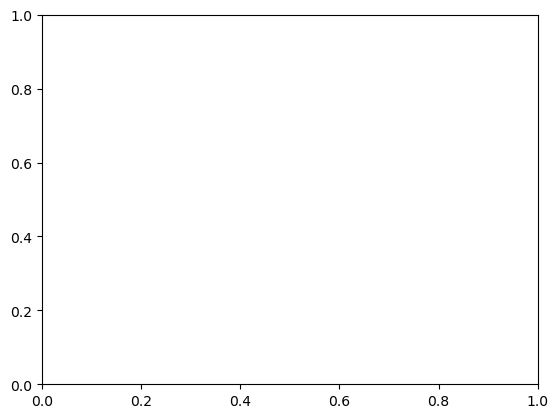

In [1358]:
fig, ax = plt.subplots()

p = 1
ax.scatter(test_y[...,p+1], y1_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0.0, 1.0)

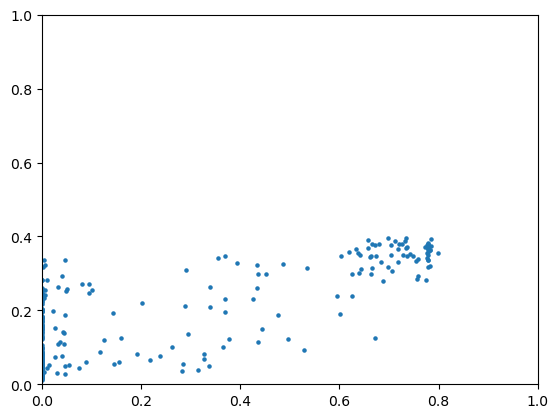

In [301]:
fig, ax = plt.subplots()

p = 1
ax.scatter(test_y[...,p+5], y2_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0.0, 1.0)

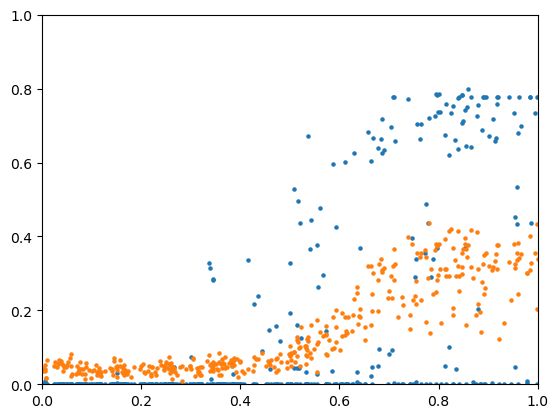

In [249]:
fig, ax = plt.subplots()

i = 3
p = 3
ax.scatter(test_x[...,i], test_y[...,p+1], s=5)
ax.scatter(test_x[...,i], y1_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0.0, 1.0)

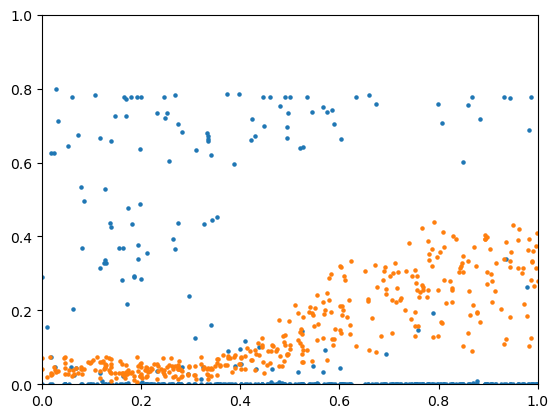

In [250]:
fig, ax = plt.subplots()

i = 1
p = 1
ax.scatter(test_x[...,i], test_y[...,p+5], s=5)
ax.scatter(test_x[...,i], y1_pred[...,p], s=5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

In [3588]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    
    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [3589]:
# # posterior predictive dist with outputs of size x.size()
# def ppd_given_input(model, x, n_samples=1000):
#     x_ = x
#     # if not x.is_cuda:
#         # x_ = x.cuda()
    
#     model.eval()
#     with torch.no_grad():
#         ppd = model(x_)

#     return ppd

# # obtain samples from ppd. get median or samples
# def sample_from_ppd(ppd, n_samples=1000, return_median=True):
#     samples = ppd.sample_n(n_samples)
#     if return_median: 
#         return samples.mode(0)[0]
#     else:
#         return samples

# lpf_ppd = ppd_given_input(
#     model=model,
#     x=test_x,
# )

# lpf_lower, lpf_upper = lpf_ppd.confidence_region()
# lpf_mean = lpf_ppd.mean
# lpf_lower, lpf_upper, lpf_mean = lpf_lower.cpu(), lpf_upper.cpu(), lpf_mean.cpu()

# lpf_ppd_train = ppd_given_input(
#     model=model,
#     x=train_x,
# )

# lpf_lower_train, lpf_upper_train = lpf_ppd_train.confidence_region()
# lpf_mean_train = lpf_ppd_train.mean
# lpf_lower_train, lpf_upper_train, lpf_mean_train = lpf_lower_train.cpu(), lpf_upper_train.cpu(), lpf_mean_train.cpu()

# # ppd of observations
# y1_ppd = dist.OrderedLogistic(lpf_mean, mu_cutpoints).to_event(1)
# y1_ppd_train = dist.OrderedLogistic(lpf_mean_train, mu_cutpoints).to_event(1)

In [3590]:
# # Draw some simulated y values
# y_sim = torch.stack(
#     [sample_from_ppd(y1_ppd)],
#     dim=-1
# ).squeeze(-1)
# y_sim_train = torch.stack(
#     [sample_from_ppd(y1_ppd_train)],
#     dim=-1
# ).squeeze(-1)

The misclassification rate for Mutual Kill reduces when adding y_1 and y_2 proportions into the model

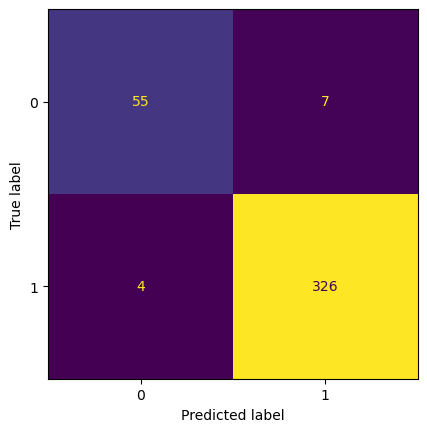

In [302]:
# outcome from using log_norm transformation
cm_test = confusion_matrix(test_y[...,-2], y3_pred)
cm_display = ConfusionMatrixDisplay(cm_test).plot(colorbar=False)
# plt.xticks(rotation=90);

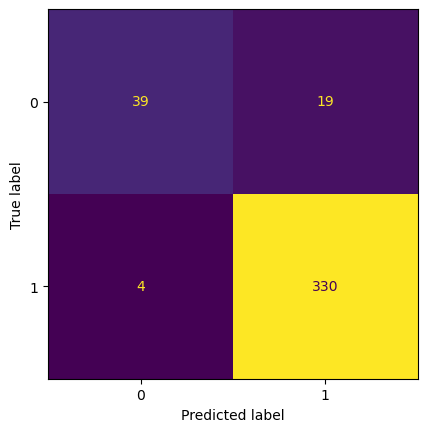

In [1931]:
# outcome from using log_norm transformation
cm_test = confusion_matrix(test_y[...,-1], y4_pred)
cm_display = ConfusionMatrixDisplay(cm_test).plot(colorbar=False)
# plt.xticks(rotation=90);

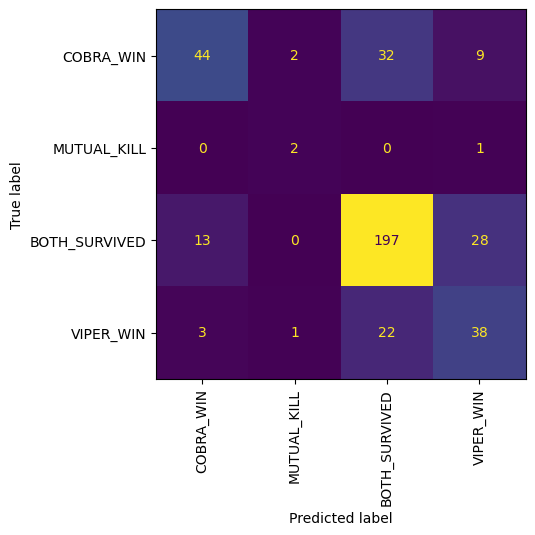

In [344]:
# outcome from using log_norm transformation
cm_outcomes = list(outcome_map.keys())[::-1]
cm_test = confusion_matrix(test_y[...,0], y0_pred)
cm_display = ConfusionMatrixDisplay(cm_test, display_labels=cm_outcomes).plot(colorbar=False)
plt.xticks(rotation=90);

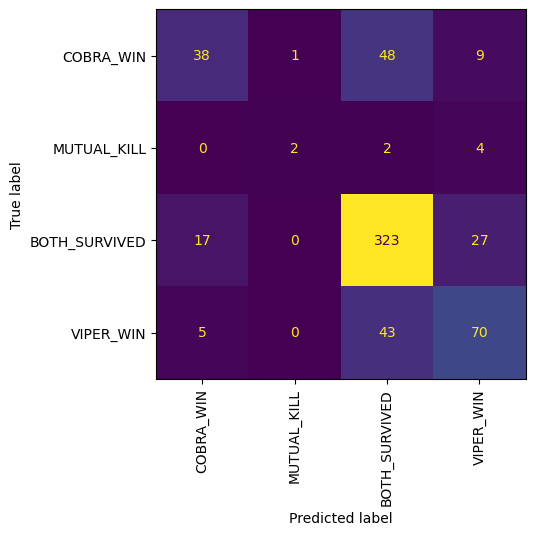

In [304]:
# outcome from using log_norm transformation
cm_train = confusion_matrix(train_y[...,0], y0_pred_train)
cm_display = ConfusionMatrixDisplay(cm_train, display_labels=cm_outcomes).plot(colorbar=False)
plt.xticks(rotation=90);

Analyse (1) independent latent function, and (2) latent parameter functions

In [345]:
model.eval()

with torch.no_grad():
    ind_latent_fn = model.variational_strategy.ind_latent_fn
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu().detach()

ilf_lower, ilf_upper = ind_latent_fn.confidence_region()
ilf_mean = ind_latent_fn.mean
# ilf_lower, ilf_upper, ilf_mean = ilf_lower.cpu(), ilf_upper.cpu(), ilf_mean.cpu()
ilf_lower, ilf_upper, ilf_mean = ilf_lower.detach().cpu(), ilf_upper.detach().cpu(), ilf_mean.detach().cpu()

In [346]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [347]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

In [348]:
outcome_l = [
    'Red Win',
    'RedBlue Killed',
    'RedBlue Survived',
    'Blue Win', 
    'Blue Neutral',
    'Blue Defense',
    'Blue Headon', 
    'Blue Offense',
    'Red Neutral', 
    'Red Defense', 
    'Red Headon', 
    'Red Offense',
    "Blue Launched",
    "Red Launched",
]

c_map = {
    'Red Win': "red",
    'RedBlue Killed': "orange",
    'RedBlue Survived': "grey",
    'Blue Win': "blue", 
    'Blue Neutral': "blue",
    'Blue Defense': "blue",
    'Blue Headon': "blue", 
    'Blue Offense': "blue",
    'Red Neutral': "red", 
    'Red Defense': "red", 
    'Red Headon': "red", 
    'Red Offense': "red",
    'Blue Launched': "blue",
    'Red Launched': "red",    
}

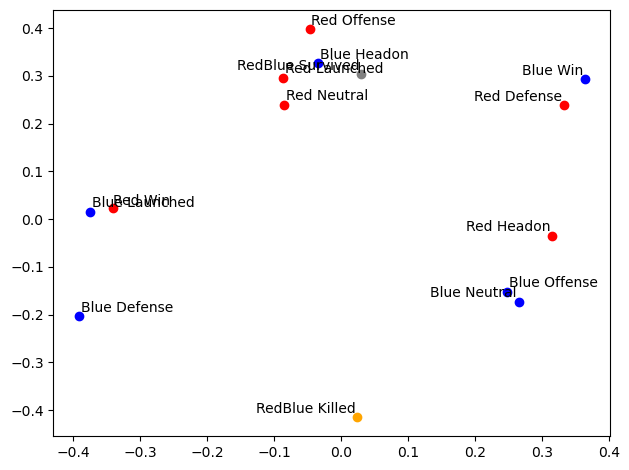

In [349]:
eigval, eigvec = eigen(lmc_coefficients, norm=True)
fig, ax = plt.subplots()
for i in range(len(outcome_l)):
    x = eigvec[i,0]
    y = eigvec[i,1]
    ax.scatter(x=x, y=y, c=c_map[outcome_l[i]])
    text = [ax.text(x, y, outcome_l[i])]
    adjust_text(text)
fig.tight_layout()
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1);

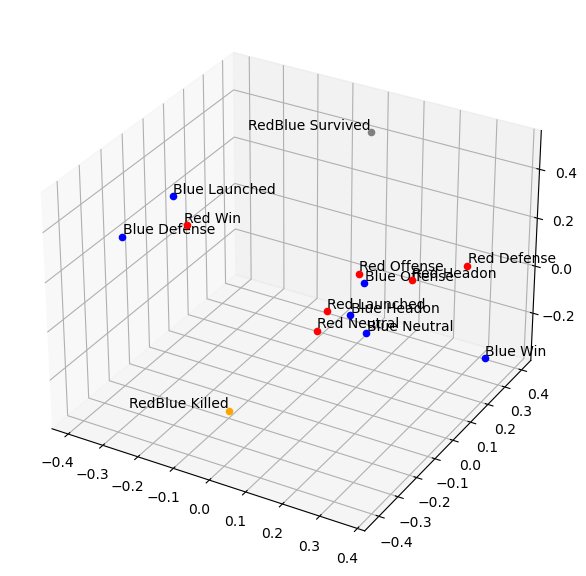

In [350]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

for i in range(len(outcome_l)):
    x = eigvec[i,0]
    y = eigvec[i,1]
    z = eigvec[i,2]
    ax.scatter3D(x, y, z, c=c_map[outcome_l[i]])
    # ax.text(x, y, z, outcome_l[i])
    text = [ax.text(x, y, z, outcome_l[i])]
    adjust_text(text)
    
fig.tight_layout()

HD: Including variance explained for each PCA component

<AxesSubplot: >

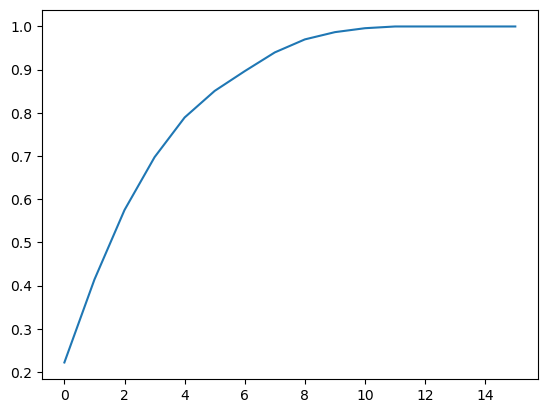

In [1940]:
r_squared = np.cumsum(eigval / eigval.sum())
sns.lineplot(x=np.arange(len(eigval)), y=r_squared)

<AxesSubplot: >

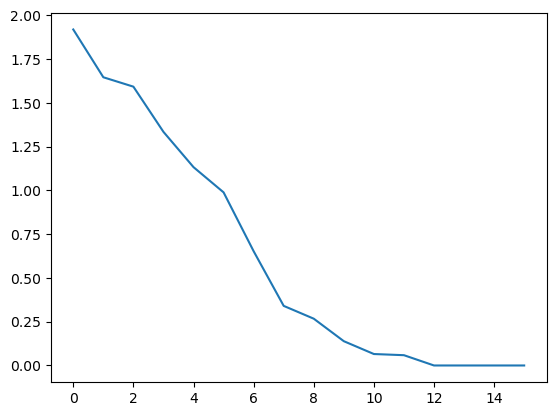

In [1817]:
sns.lineplot(x=np.arange(len(eigval)), y=eigval)

In [351]:
inputs = [
    # "viper_launched",
    # 'viper_launch_range',
    'viper_briefed_launch_range',
    'viper_briefed_evasion_range',
    # "cobra_launched",
    # 'cobra_launch_range',
    'cobra_briefed_launch_range',
    'cobra_briefed_evasion_range',
    # 'launch_range_diff',
    # 'evasion_range_diff'
]

In [352]:
# # visualize the result
# input_dim = train_x.size(-1)
# num_latents = ilf_mean.size(0)
# n_categories = 4

# # visualize the result
# fig, func = plt.subplots(nrows=num_latents, ncols=1, figsize=(20, 20), sharey=True)
# # x="x"

# # for j in range(input_dim):
# row = 0
# for i in range(num_latents):
#     print(i, j)
#     # if j == active_dims[i][0]:
#     indices = np.argsort(train_x[:,j])
#     line = func[row].scatter(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
#     func[row].fill_between(
#         train_x[indices,j], ilf_lower[i,indices],
#         ilf_upper[i,indices], alpha=0.1, #color=line.get_color()
#     )
#     # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
#     func[row].set_xlabel(inputs[j], fontdict={'fontsize':20})
#     func[row].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
#     func[row].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
#     func[row].set_xlim([0.,1.])
#     row += 1

# fig.tight_layout()

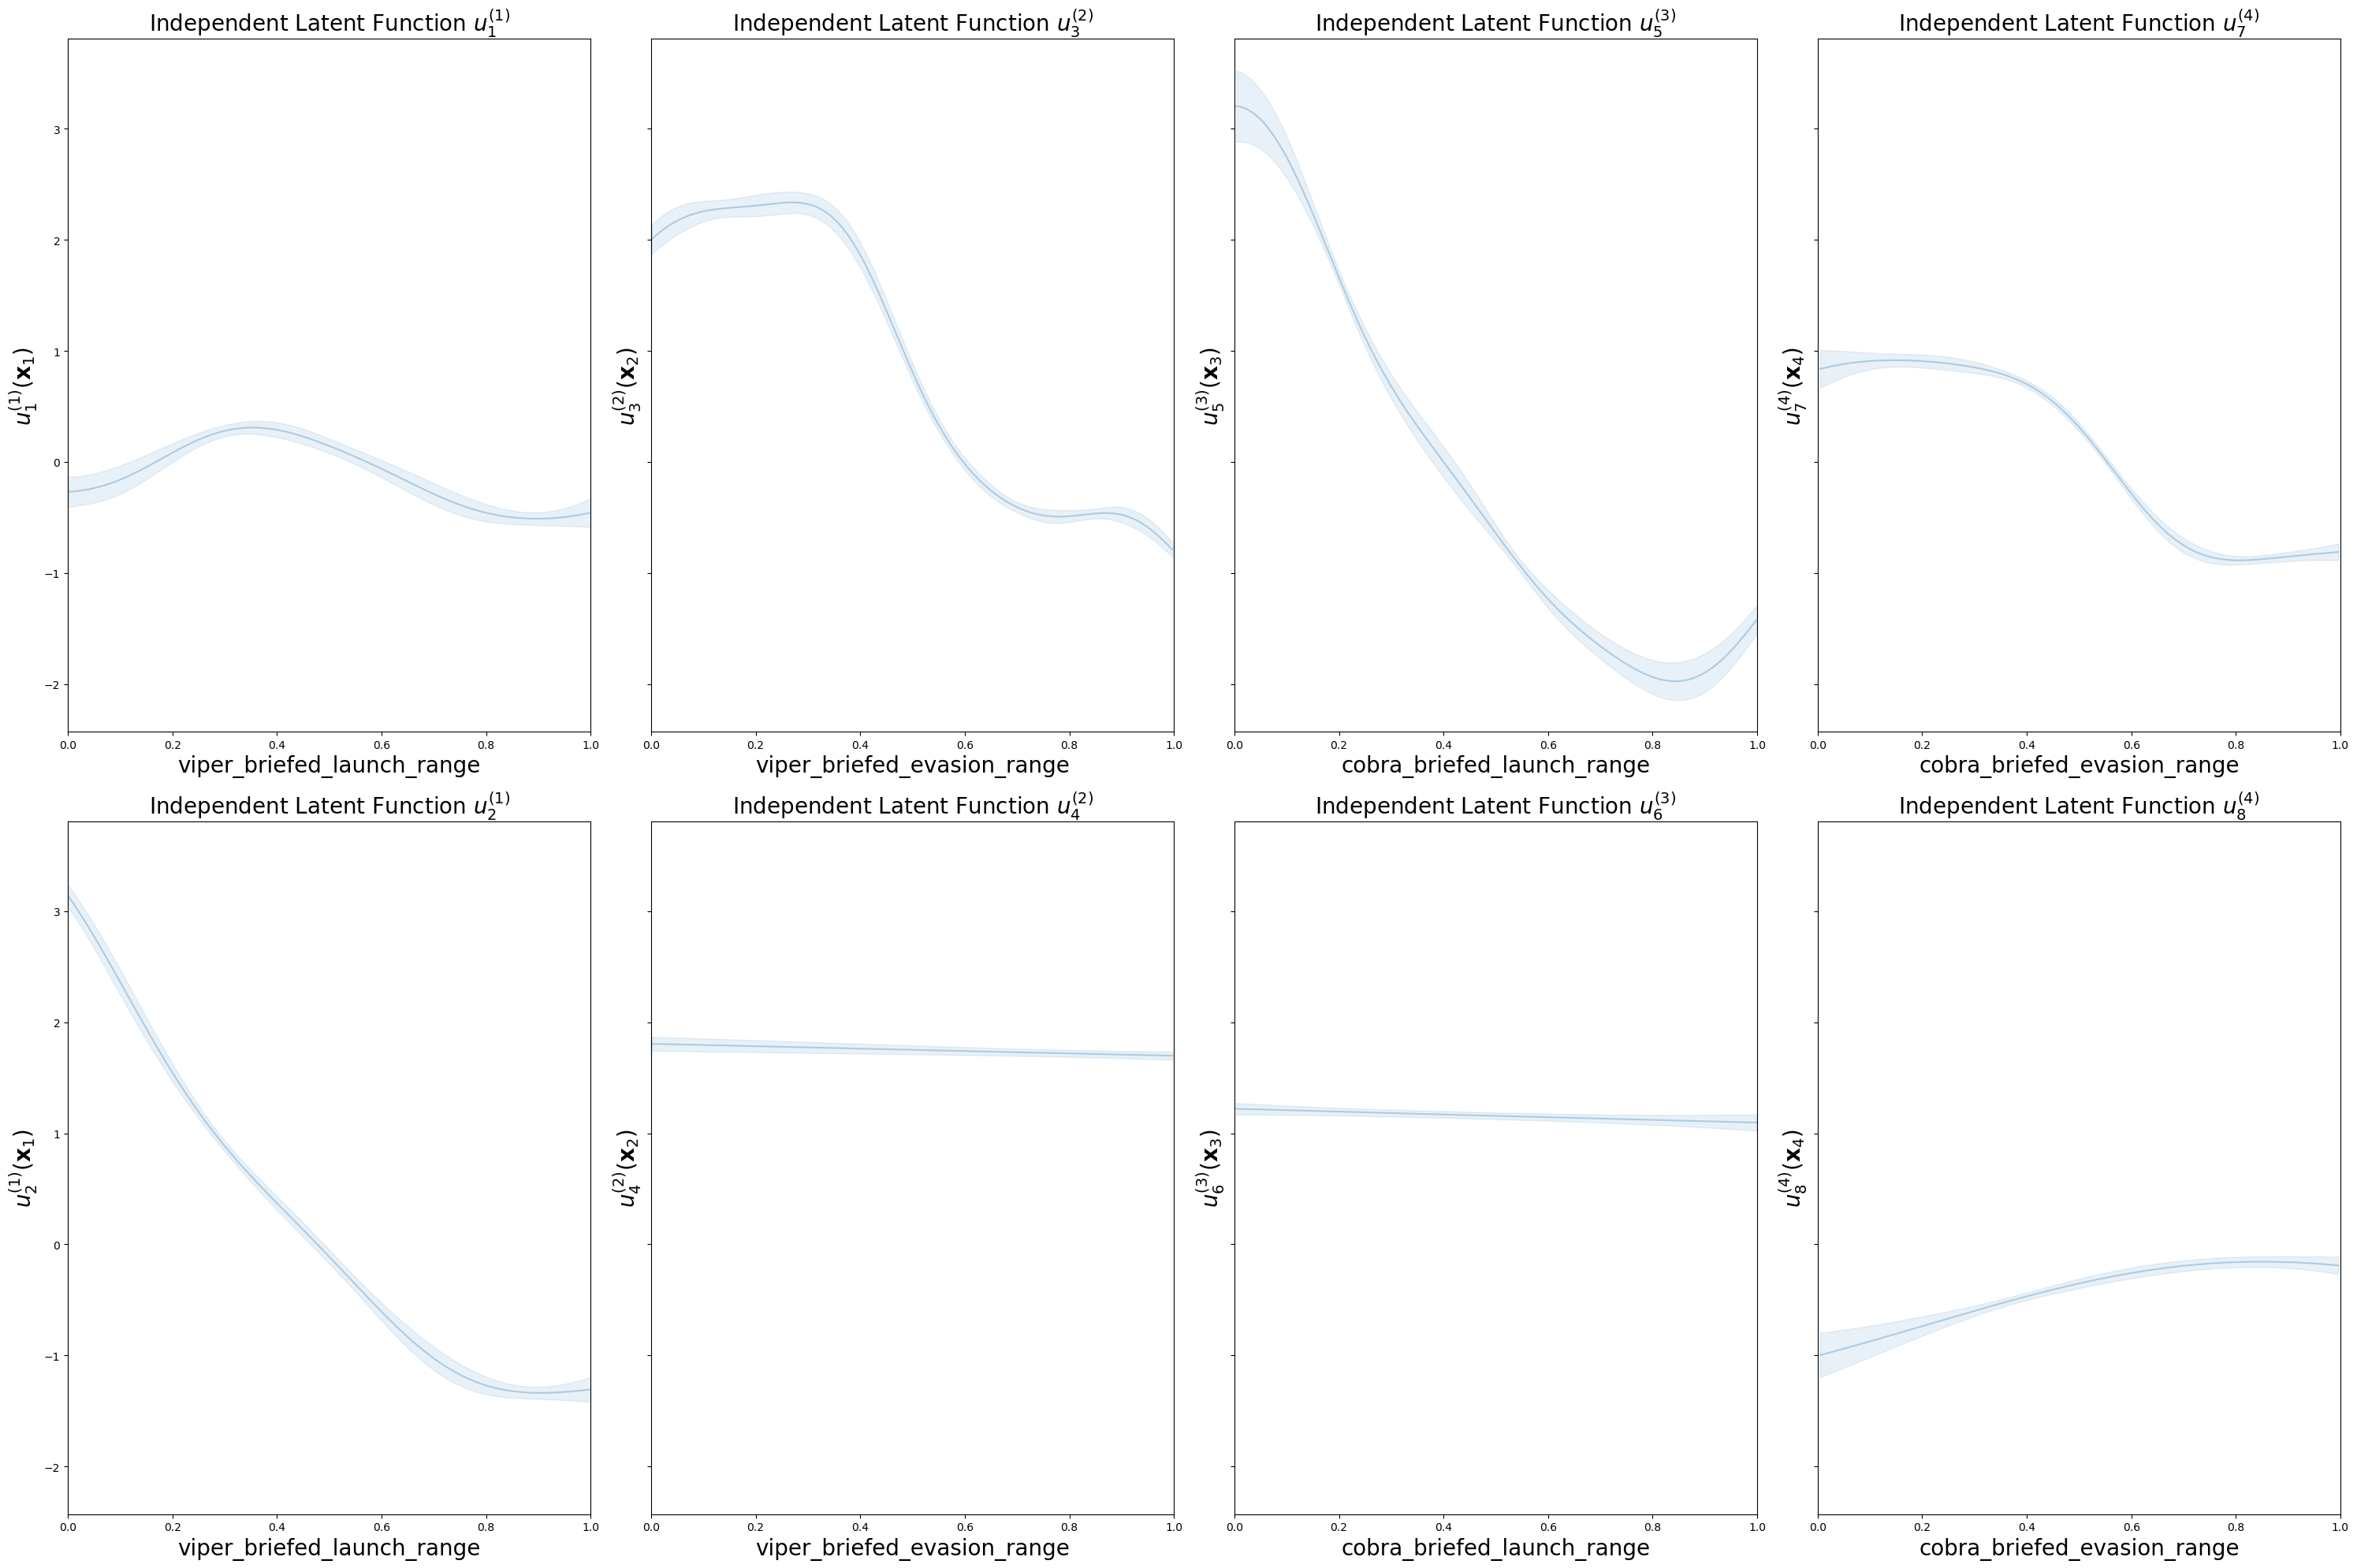

In [353]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=num_latents // input_dim, ncols=input_dim, figsize=(30, 20), sharey=True)
# x="x"

for j in range(input_dim):
    row = 0
    for i in range(num_latents):
        # print(i, j)
        if j == active_dims[i][0]:
            indices = np.argsort(train_x[:,j])
            line, = func[row,j].plot(train_x[indices,j], ilf_mean[i,indices], alpha=0.3)
            func[row,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.1, color=line.get_color()
            )
            # func[row,j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
            func[row,j].set_ylabel(f"${{u_{{{i+1}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
            func[row,j].set_title(f"Independent Latent Function ${{u_{{{i+1}}}^{{({j+1})}}}}$", fontdict={'fontsize':20})
            func[row,j].set_xlim([0.,1.])
            row += 1

fig.tight_layout()

In [354]:
def compute_f_pd_p(x, input_dim, output_d, ilf, lmc, active_dims, get_indices=True):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,output_d]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

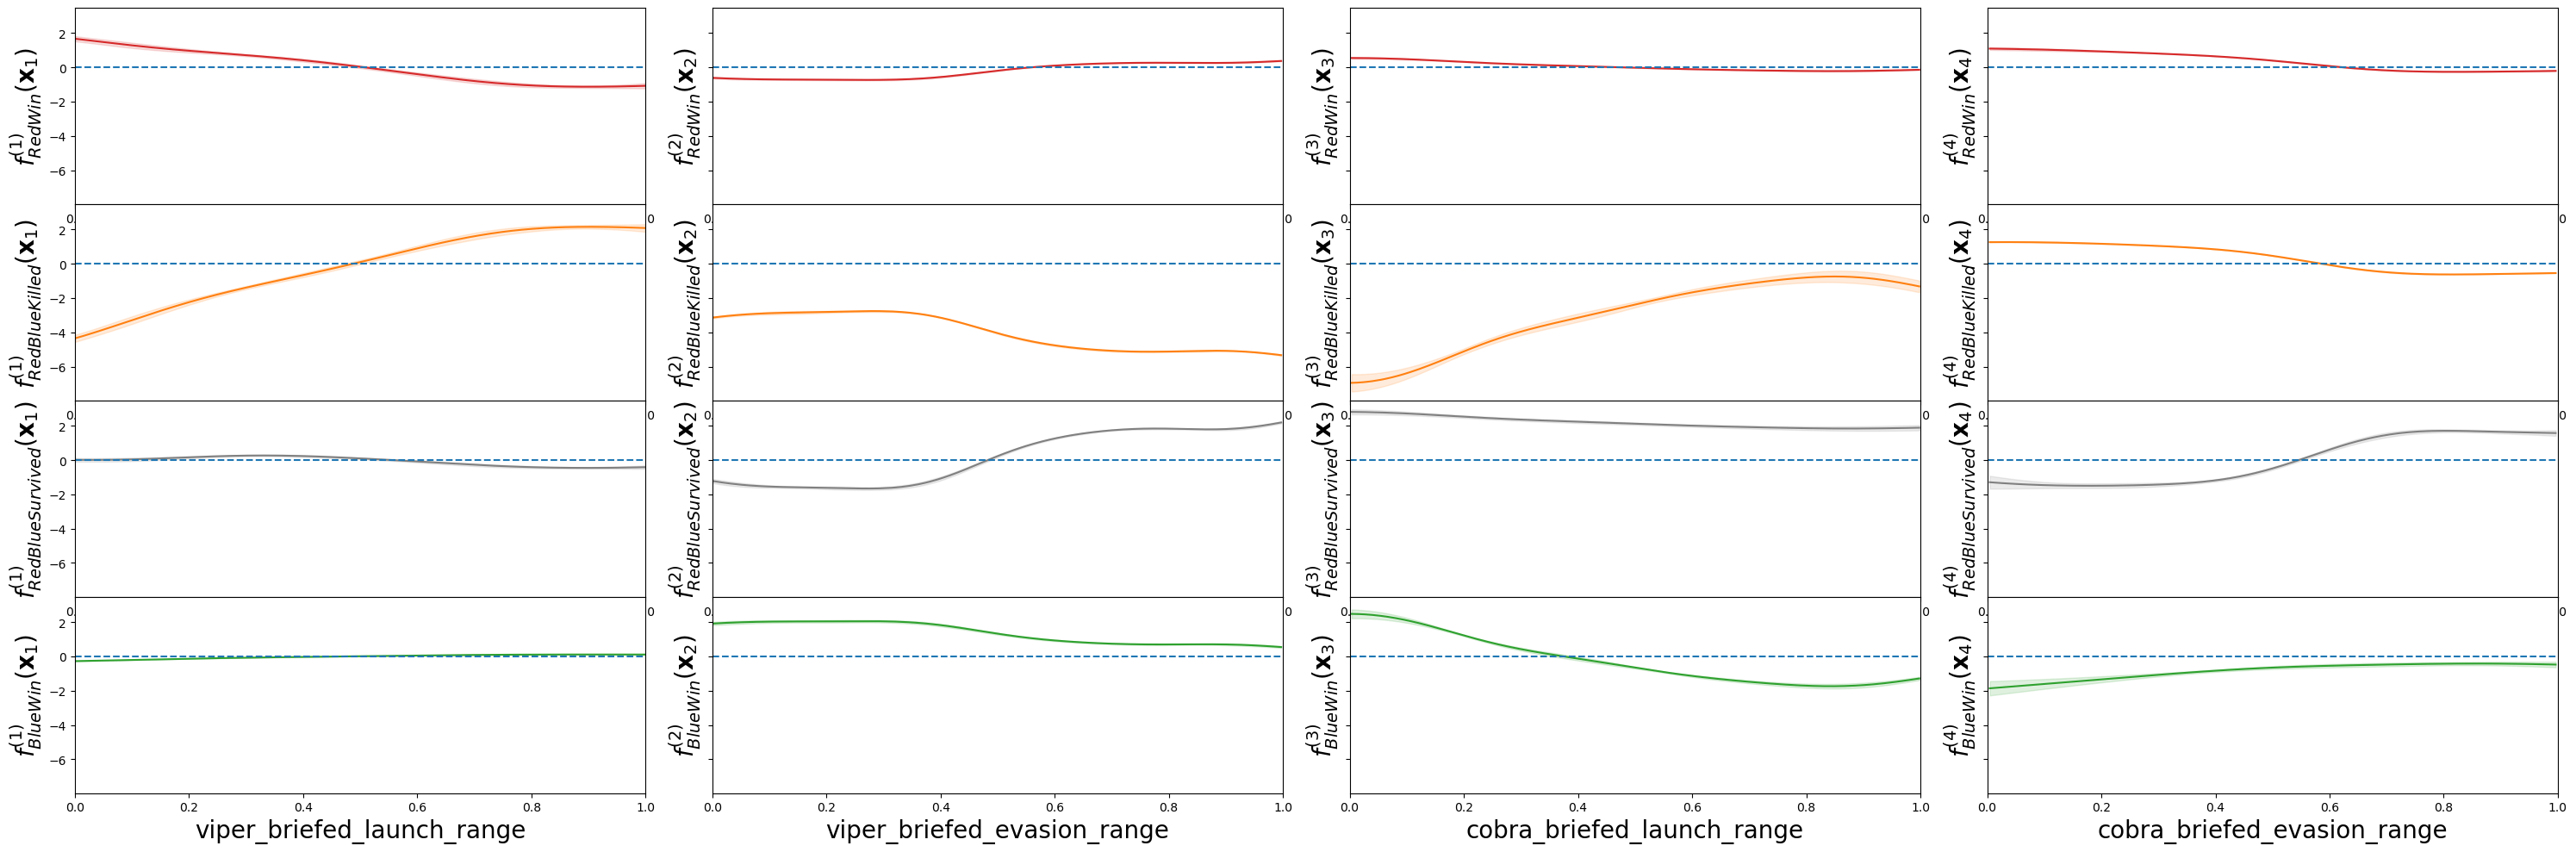

In [355]:
# visualize the result
categories = outcome_l[:4]
input_dim = train_x.size(-1)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=n_categories, ncols=input_dim, figsize=(30, 10), sharey=True)
c = ["tab:red", "tab:orange", "tab:gray", "tab:green"]
# c = ["tab:red", "tab:gray", "tab:green"]

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        # print(f"plot ({inputs[j]}, {categories[row]}) in row={row}, col={j}")
        indices = np.argsort(train_x[:,j]) 
        indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
        line, = func[row,j].plot(train_x[indices,j], f_mean, alpha=0.99, c=c[row])
        func[row,j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.15, color=line.get_color()
        )
        func[row,j].set_xlabel(inputs[j], fontdict={'fontsize':20})
        func[row,j].set_ylabel(f"${{f_{{{categories[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[row,j].set_xlim([0.,1.])
        func[row,j].hlines(0, 0, 1, ls="--")
        row += 1

fig.tight_layout()
fig.subplots_adjust(hspace=0)

In [356]:
c_map = {
    # "cobra_launched": "red",
    # "cobra_launch_range": "maroon",
    "cobra_briefed_launch_range": "maroon",
    "cobra_briefed_evasion_range": "indianred",
    # "viper_launched": "blue",
    # "viper_launch_range": "navy",
    "viper_briefed_launch_range": "navy",
    "viper_briefed_evasion_range": "royalblue",
    "launch_range_diff": "darkgoldenrod",
    "evasion_range_diff": "black",
}

ls_map = {
    # "viper_launched": ":",
    # 'viper_launch_range': "-",
    'viper_briefed_launch_range': "-",
    'viper_briefed_evasion_range': "-.",
    # "cobra_launched": ":",
    # 'cobra_launch_range': "-",
    'cobra_briefed_launch_range': "-",
    'cobra_briefed_evasion_range': "-.",
    "launch_range_diff": ":",
    "evasion_range_diff": ":",
}

alpha_map = {
    "viper_launched": .9,
    # 'viper_launch_range': .9,
    'viper_briefed_launch_range': .9,
    'viper_briefed_evasion_range': .9,
    "cobra_launched": .9,
    # 'cobra_launch_range': .9,
    'cobra_briefed_launch_range': .9,
    'cobra_briefed_evasion_range': .9,
    "launch_range_diff": .9,
    "evasion_range_diff": .9,
}

Text(0.0, -13.5, 'scotts_pi score: 0.4793')

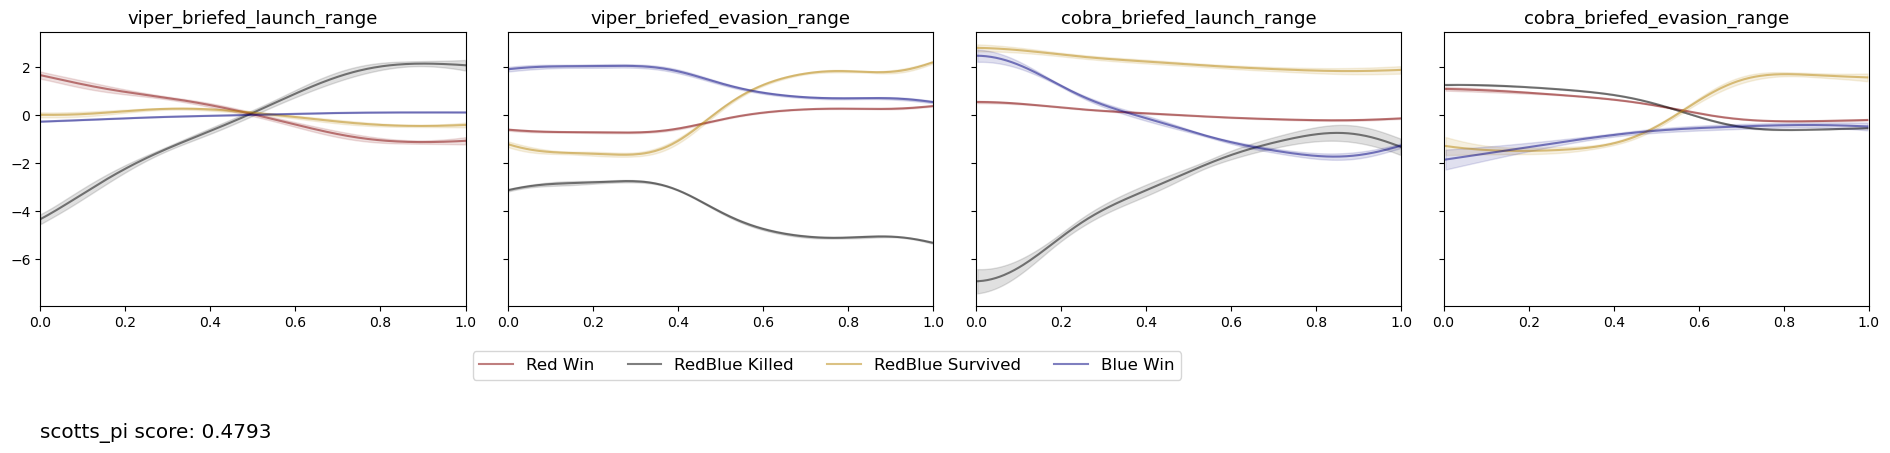

In [357]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)

# visualize the result
fig, func = plt.subplots(ncols=input_dim, figsize=(19, 3.5), sharey=True)
# x="x"

c = ["maroon", "black", "darkgoldenrod", "navy"]

ilf_idx = 0
for j in range(input_dim):
    for i in range(n_categories):
        c_ = c[i]
        ls = ls_map[inputs[j]]
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, i, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, i, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, i, ilf_upper, lmc_coefficients, active_dims)
        line, = func[j].plot(train_x[indices,j], f_mean, alpha=0.5, label=categories[i], c=c_)
        func[j].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[j].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[j].set_xlabel(inputs[j], fontdict={'fontsize':10})
        # func[j].set_ylabel(f"${{f_{{{outcome_l[i]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[j].set_title(inputs[j], fontdict={'fontsize':13})
        func[j].set_xlim([0.,1.])
        # func[j].hlines(0, 0, 1, ls="--")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(.75, -.3), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -13.5), fontsize="x-large", annotation_clip=False)

Text(0.0, -14.2, 'scotts_pi score: 0.4793')

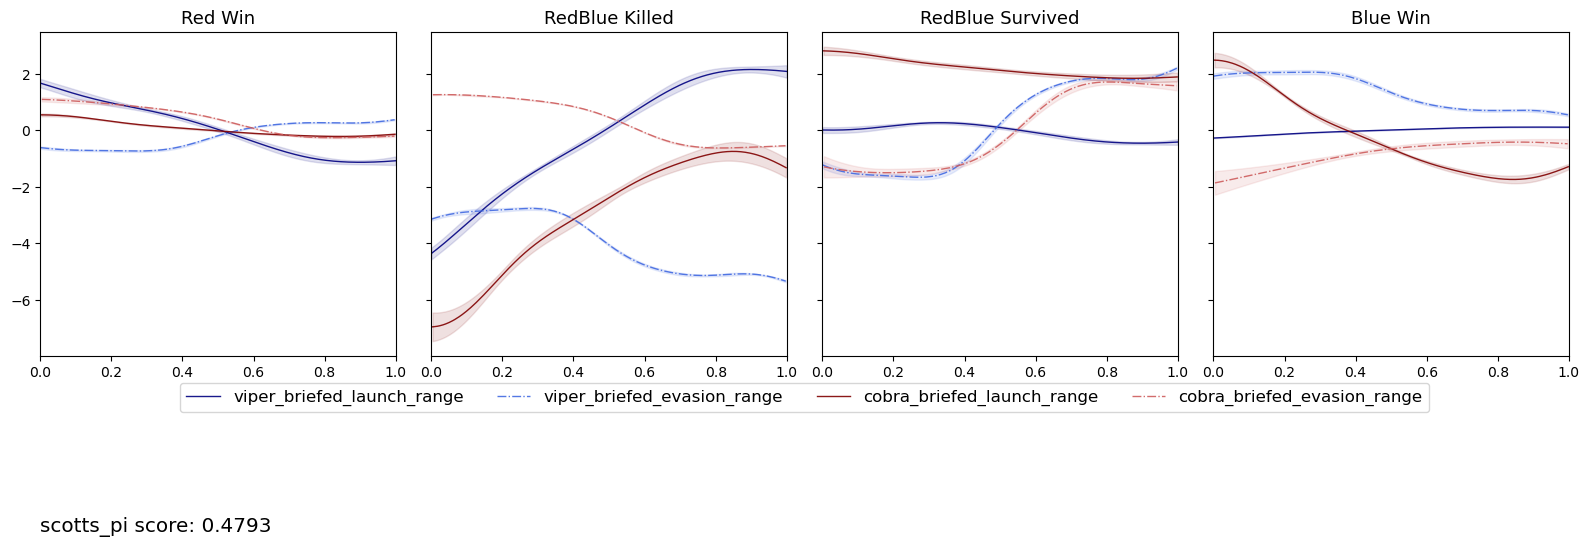

In [358]:
# visualize the result
input_dim = train_x.size(-1)
num_latents = ilf_mean.size(0)
n_categories = 4

# visualize the result
fig, func = plt.subplots(nrows=1, ncols=n_categories, figsize=(16, 4), sharey=True)

for j in range(input_dim):
    row = 0
    for i in range(n_categories):
        c = c_map[inputs[j]]
        ls = ls_map[inputs[j]]
        alpha = alpha_map[inputs[j]]
        indices = np.argsort(train_x[:,j])
        indices, f_mean = compute_f_pd_p(train_x, j, row, ilf_mean, lmc_coefficients, active_dims)
        _, f_lower = compute_f_pd_p(train_x, j, row, ilf_lower, lmc_coefficients, active_dims)
        _, f_upper = compute_f_pd_p(train_x, j, row, ilf_upper, lmc_coefficients, active_dims)
        line, = func[row].plot(train_x[indices,j], f_mean, alpha=alpha, lw=1, label=inputs[j], c=c, ls=ls)
        func[row].fill_between(
            train_x[indices,j], f_lower,
            f_upper, alpha=0.12, color=line.get_color()
        )
        # func[row].set_xlabel(f"${{\mathbf{{x}}_{{{j+1}}}}}$", fontdict={'fontsize':20})
        # func[row].set_ylabel(f"${{f_{{{outcome_l[row]}}}^{{({j+1})}}(\mathbf{{x}}_{{{j+1}}})}}$", fontdict={'fontsize':20})
        func[row].set_title(categories[row], fontdict={'fontsize':13})
        # func[row].hlines(0, 0, 1, ls="-", color="k", lw=.5)
        func[row].set_xlim([0.,1.])
        # func[row].legend()
        row += 1

fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
func[1].legend(bbox_to_anchor=(1.05, -.2), loc="lower center",  ncol = len(func[1].lines),
               prop={'size': 12})

score = scotts_pi(cm_test, weight_type="unweighted")
func[0].annotate(f"scotts_pi score: {score}", (0.0, -14.2), fontsize="x-large", annotation_clip=False)

#### computation and plots for parsimonious model

In [1]:
lmc_df.iloc[0,-1].size

NameError: name 'lmc_df' is not defined

In [83]:
# Sturge's formula for calculating n_bins
# n_bins = int(np.ceil(np.log2(lmc_coeffs["21"].size(0))) + 1)

lmc_concat = np.concatenate([np.abs(lmc_df.iloc[-1,-1]), np.abs(lmc_df.iloc[1,-1])])
# bin_width = round(lmc_concat.max() / n_bins,2)
# bins = np.arange(0, lmc_concat.max()+.2, step=bin_width)
bins = np.linspace(0, lmc_concat.max()+.1, lmc_df.iloc[-1,-1].size)
count_01, _ = np.histogram(np.abs(lmc_df.iloc[-1,-1]), 
                           bins=bins)
count_21, _ = np.histogram(np.abs(lmc_df.iloc[1,-1]), 
                           bins=bins)

<AxesSubplot: ylabel='Count'>

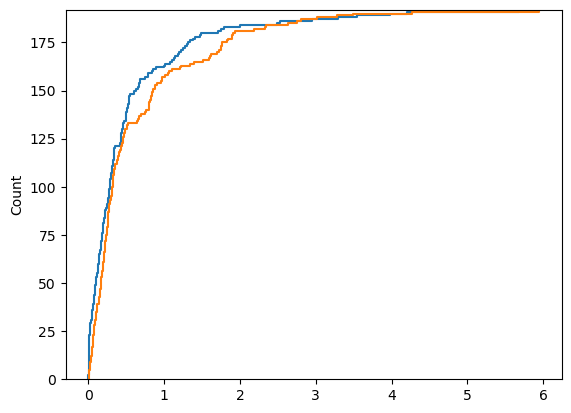

In [84]:
sns.ecdfplot(np.abs(lmc_df.iloc[1,-1]), stat="count")
sns.ecdfplot(np.abs(lmc_df.iloc[-1,-1]), stat="count")

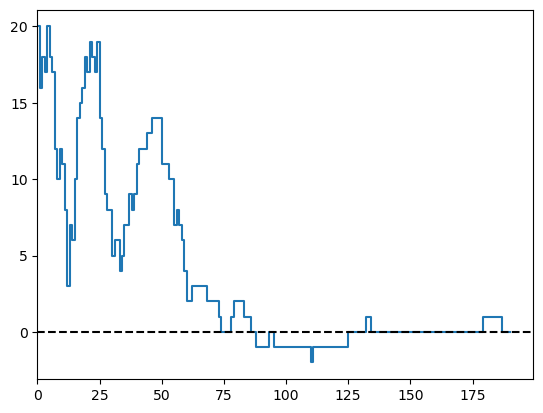

In [85]:
fig, ax = plt.subplots()

ax.step(x=np.arange(len(count_21)), y=count_21.cumsum() - count_01.cumsum(), where="post")
ax.set_xlim(0)
_, xmax = ax.get_xlim()
ax.hlines(0, 0, xmax, ls="--", colors="black")
# ax.set_xticks(np.arange(0, len(bins)))
# ax.set_xticklabels(bins)
# ax.set_xticks([0,1,2],rotate=90)

Explain reason for omitting signal variance for model

<AxesSubplot: ylabel='Density'>

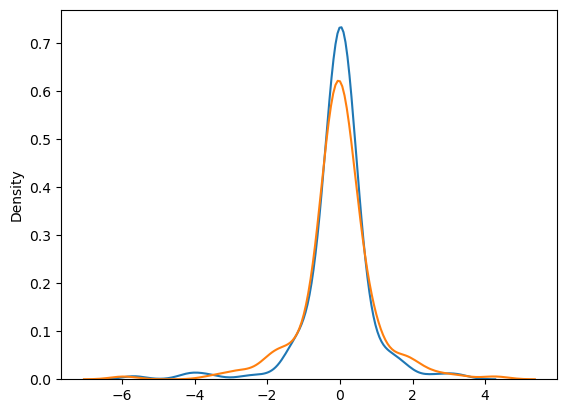

In [86]:
sns.kdeplot(lmc_df.iloc[1,-1])
sns.kdeplot(lmc_df.iloc[-1,-1])